In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.backends.backend_pdf import PdfPages
from supermodel import sigmoid, tau_fun, tau_fun2
from scipy.optimize import curve_fit

%matplotlib inline

ImportError: No module named supermodel

## IMPORTANT: choose 2nd order or 3rd order

In [8]:
tau_order = 2
if tau_order == 2:
    tau_fit_fcn = tau_fun2
elif tau_order == 3:
    tau_fit_fcn = tau_fun
else:
    print("Order must be two or three.")

## load steady-state activations/inactivations and time constants for models in ICG database

In [3]:
import sys
sys.path.insert(0, '../data_extracted/')
from extract_df import get_values

# names: path to files
# types: ion type
# variable: INF or TAU
# traces: np array of traces:
#   NOTE:  if the first element of a row is "None" it indicates only 21 values
#    can be found in this row, which are located in the last 21 row cells
# df_whole: whole dataframe
names, types, variables, traces, df_whole = get_values(directory="../data_raw/")

In [4]:
v = np.linspace(-150,150,61)  # most models have 61 data points
v2 = np.linspace(-100,100,21)  # some models only have 21 data points

ion_type = types.tolist()
curve_type = variables.tolist()
fnames = names.tolist()
fnames_unique = list(set(fnames))
num_curves = len(fnames)
num_models = len(fnames_unique)
print('number of models: ',num_models)

number of models:  1755


In [6]:
# inspect data traces for invalid models

to_remove = []

for i in range(num_models):
    
    # get indices of all data curves for this model (all curves with the same file name)
    inds = [j for j, x in enumerate(fnames) if x == fnames_unique[i]]
    inf_inds = [j for j in inds if curve_type[j] == 'INF']
    tau_inds = [j for j in inds if curve_type[j] == 'TAU']
    
    # steady-state curves
    for j in range(len(inf_inds)):
        if np.isnan(traces[inf_inds[j],0]):     # check if this file is one with only 21 data points
            data = traces[inf_inds[j],-21:]
            V = v2
        else:                                   # normal file with 61 data points
            data = traces[inf_inds[j],:]
            V = v
        if np.max(data) > 1.1 or np.min(data) < 0.0:
            print('Weird INF file nr. %d, fname %s' %(inf_inds[j],fnames_unique[i]))
            to_remove.append(fnames_unique[i])
    
    # tau curves
    for j in range(len(tau_inds)):
        if np.isnan(traces[tau_inds[j],0]):     # check if this file is one with only 21 data points
            data = traces[tau_inds[j],-21:]
            V = v2
        else:                                   # normal file with 61 data points
            data = traces[tau_inds[j],:]
            V = v
        if np.max(data) < 1e-6:
            print('Weird TAU file nr. %d, fname %s' %(tau_inds[j],fnames_unique[i]))
            to_remove.append(fnames_unique[i])
    
to_remove_unique = list(set(to_remove))
print('Found %d invalid models, removing...' % len(to_remove_unique))
fnames_unique = [n for n in fnames_unique if n not in to_remove_unique]
num_models = len(fnames_unique)
print('Total number of models is now %d.' % num_models)

Found 0 invalid models, removing...
Total number of models is now 1668.


## fit supermodel to steady-state activations/inactivations and time constants across models

In [9]:
# loop through all models and fit curves

n_vars = []           # number of gating variables
model_rms = []        # RMS for full model -- all INF and TAU curves of a particular model
model_iontype = []
total_popt = []
total_traces = []
total_rms = []        # RMS for each curve separately
total_iontype = []
total_curvetype = []
total_fnames = []

c = 0
skip_files = []
maxfev = 20000

for i in range(num_models):
    
    # get indices of all data curves for this model (all curves with the same file name)
    inds = [j for j, x in enumerate(fnames) if x == fnames_unique[i]]
    inf_inds = [j for j in inds if curve_type[j] == 'INF']
    tau_inds = [j for j in inds if curve_type[j] == 'TAU']
    n_vars.append(len(inf_inds))
    
    # for computing the total RMS of all INF and TAU curves of a particular model
    total_data = []
    total_fit = []

    # fit steady-state curves
    for j in range(len(inf_inds)):
        if np.isnan(traces[inf_inds[j],0]):     # check if this file is one with only 21 data points
            data = traces[inf_inds[j],-21:]
            V = v2
        else:                                   # normal file with 61 data points
            data = traces[inf_inds[j],:]
            V = v
        if np.max(data) > 1.1 or np.min(data) < 0.0:
            print('Weird INF file nr. %d, fname %s' %(inf_inds[j],fnames_unique[i]))
        try:
            p0 = np.random.rand(2)
            popt, _ = curve_fit(sigmoid, V, data, p0=p0, maxfev=maxfev)
            total_fit += list(sigmoid(V, *popt))
            total_data += list(data)
            nrmse = np.sqrt(np.mean((np.asarray(data)-np.asarray(sigmoid(V, *popt)))**2))/np.std(np.asarray(data))
            total_rms.append(nrmse)
            total_popt.append(popt)
            total_iontype.append(ion_type[inf_inds[j]])
            total_curvetype.append(curve_type[inf_inds[j]])
            total_traces.append(data)
            total_fnames.append(fnames_unique[i])
        except RuntimeError as err:
            print('INF Runtime error with file nr. %d, %s, ignoring...' % (inf_inds[j],fnames_unique[i]))
            c += 1
            skip_files.append(fnames_unique[i])
            print(err)
     
    # fit tau curves
    for j in range(len(tau_inds)):
        if np.isnan(traces[tau_inds[j],0]):     # check if this file is one with only 21 data points
            data = traces[tau_inds[j],-21:]
            V = v2
        else:                                   # normal file with 61 data points
            data = traces[tau_inds[j],:]
            V = v
        if np.max(data) < 1e-6:
            print('Weird TAU file nr. %d, fname %s' %(tau_inds[j],fnames_unique[i]))
        try:
            if tau_order == 3:
                p0 = [V[np.argmax(data)],np.mean(data)] + [0]*6  # NOTE: initialization is very important
            else:
                p0 = [V[np.argmax(data)],np.mean(data)] + [0]*4
            popt, _ = curve_fit(tau_fit_fcn, V, data, p0=p0, maxfev=maxfev)
            total_fit += list(tau_fit_fcn(V, *popt)) #list(tau_fun(V, *popt))
            total_data += list(data)
            nrmse = np.sqrt(np.mean((np.asarray(data)-np.asarray(tau_fit_fcn(V, *popt)))**2))/(np.std(np.asarray(data))+1e-6)
            total_rms.append(nrmse)
            total_popt.append(popt)
            total_iontype.append(ion_type[tau_inds[j]])
            total_curvetype.append(curve_type[tau_inds[j]])
            total_traces.append(data)
            total_fnames.append(fnames_unique[i])
        except RuntimeError as err:
            print('TAU Runtime error with file nr. %d, %s, ignoring...' % (tau_inds[j],fnames_unique[i]))
            c += 1
            skip_files.append(fnames_unique[i])
            print(err)
    
    # compute the total RMS for all INF and TAU curves of model i
    model_rms.append(np.sqrt(np.mean((np.asarray(total_data)-np.asarray(total_fit))**2)))
    model_iontype.append(ion_type[tau_inds[0]])
    
print('Avg. RMS = ', np.mean([x for x in total_rms if ~np.isnan(x)]))
print('Var = ', np.var(total_rms))
print('Nr skipped traces = ',c)
print('Nr skipped files = ',len(list(set(skip_files))))


/Users/wfpodlaski/Documents/ICGenealogy/ox-caesar/channelomics/test_supermodel/supermodel.py:13: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2)) + np.exp(e*y+f*y**2))
/Users/wfpodlaski/Documents/ICGenealogy/ox-caesar/channelomics/test_supermodel/supermodel.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a*x+b))
/Users/wfpodlaski/anaconda/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


TAU Runtime error with file nr. 6288, ../data_raw/Na/62285_SS.mod, ignoring...
Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
TAU Runtime error with file nr. 4179, ../data_raw/K/126640_kas.mod, ignoring...
Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
TAU Runtime error with file nr. 3482, ../data_raw/Ca/146565_CaT.mod, ignoring...
Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
TAU Runtime error with file nr. 4281, ../data_raw/K/138321_kaprox.mod, ignoring...
Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
TAU Runtime error with file nr. 6286, ../data_raw/Na/62285_B_NA.mod, ignoring...
Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
TAU Runtime error with file nr. 3361, ../data_raw/Ca/136095_ntt.mod, ignoring...
Optimal parameters not found: Number of calls to function has reached maxfev = 20000.

K
TAU
3.94


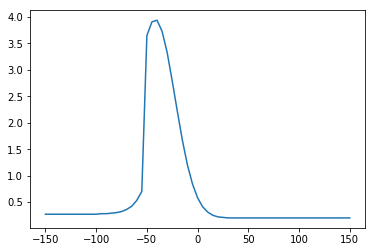

In [6]:
# look at individual traces
i = 4310
if np.isnan(traces[i,0]):     # check if this file is one with only 21 data points
    data = traces[i,-21:]
    V = v2
else:                                   # normal file with 61 data points
    data = traces[i,:]
    V = v

print(ion_type[i])
print(curve_type[i])
print(np.max(data))
plt.plot(V,data)

## plot histograms and summary stats

Text(0.5,1,'RMS (range 100 to 4000)')

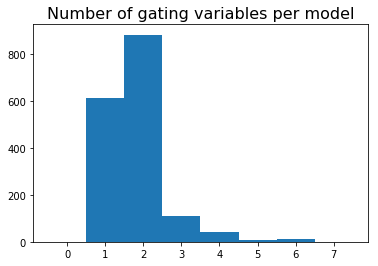

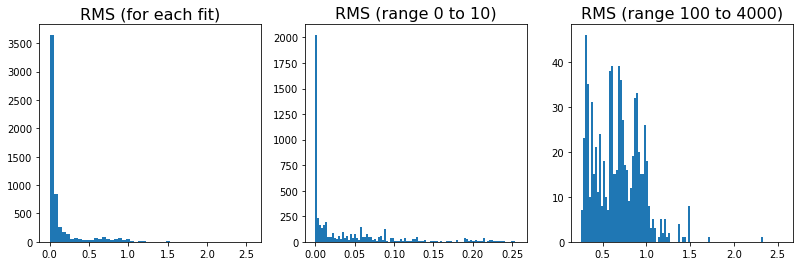

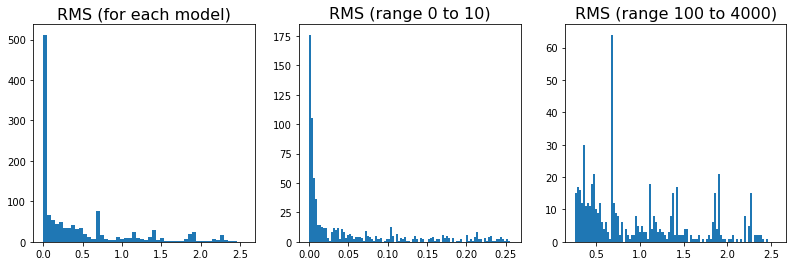

In [10]:
# plotting

maxval = 1.1*np.max(total_rms)

# histogram of number of gating variables per model
plt.figure()
h = plt.hist(n_vars,range=(0,8),bins=8)
plt.title('Number of gating variables per model',fontsize=16)
plt.xticks(np.arange(0.5,8.5),np.arange(0,8))

# histogram of RMS of all individual fits
plt.figure(figsize=(13.5,4))
plt.subplot(131)
h = plt.hist(total_rms,range=(0,maxval),bins=50)
plt.title('RMS (for each fit)',fontsize=16)
plt.subplot(132)
h = plt.hist(total_rms,range=(0,maxval/10.),bins=100)
plt.title('RMS (range 0 to 10)',fontsize=16)
plt.subplot(133)
h = plt.hist(total_rms,range=(maxval/10,maxval),bins=100)
plt.title('RMS (range 100 to 4000)',fontsize=16)

# histogram of RMS of all model fits
plt.figure(figsize=(13.5,4))
plt.subplot(131)
h = plt.hist(model_rms,range=(0,maxval),bins=50)
plt.title('RMS (for each model)',fontsize=16)
plt.subplot(132)
h = plt.hist(model_rms,range=(0,maxval/10.),bins=100)
plt.title('RMS (range 0 to 10)',fontsize=16)
plt.subplot(133)
h = plt.hist(model_rms,range=(maxval/10,maxval),bins=100)
plt.title('RMS (range 100 to 4000)',fontsize=16)


Text(0.5,1,'CAV, TAU')

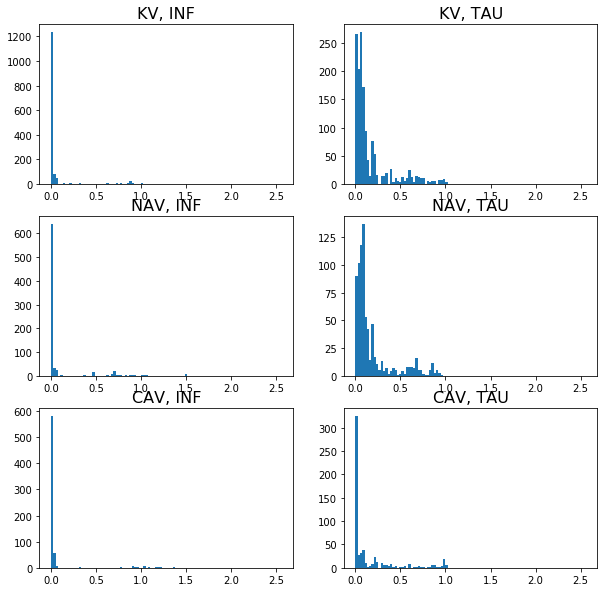

In [11]:
# plotting for each individual ion type and separately for INF and TAU

maxrange = 1.1*np.max(total_rms)

plt.figure(figsize=(10,10))
plt.subplot(321)
rms_vals = [x for i,x in enumerate(total_rms) if (total_iontype[i] == 'K' and total_curvetype[i] == 'INF')]
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('KV, INF',fontsize=16)
plt.subplot(322)
rms_vals = [x for i,x in enumerate(total_rms) if (total_iontype[i] == 'K' and total_curvetype[i] == 'TAU')]
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('KV, TAU',fontsize=16)
plt.subplot(323)
rms_vals = [x for i,x in enumerate(total_rms) if (total_iontype[i] == 'Na' and total_curvetype[i] == 'INF')]
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('NAV, INF',fontsize=16)
plt.subplot(324)
rms_vals = [x for i,x in enumerate(total_rms) if (total_iontype[i] == 'Na' and total_curvetype[i] == 'TAU')]
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('NAV, TAU',fontsize=16)
plt.subplot(325)
rms_vals = [x for i,x in enumerate(total_rms) if (total_iontype[i] == 'Ca' and total_curvetype[i] == 'INF')]
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('CAV, INF',fontsize=16)
plt.subplot(326)
rms_vals = [x for i,x in enumerate(total_rms) if (total_iontype[i] == 'Ca' and total_curvetype[i] == 'TAU')]
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('CAV, TAU',fontsize=16)

Text(0.5,1,'CAV')

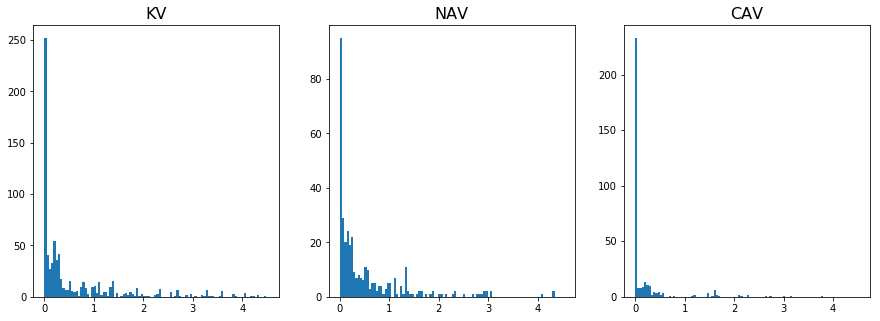

In [11]:
# plotting for each individual ion type and separately for INF and TAU

plt.figure(figsize=(15,5))
plt.subplot(131)
rms_vals = [x for i,x in enumerate(model_rms) if model_iontype[i] == 'K']
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('KV',fontsize=16)
plt.subplot(132)
rms_vals = [x for i,x in enumerate(model_rms) if model_iontype[i] == 'Na']
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('NAV',fontsize=16)
plt.subplot(133)
rms_vals = [x for i,x in enumerate(model_rms) if model_iontype[i] == 'Ca']
h = plt.hist(rms_vals,range=(0,maxrange),bins=100)
plt.title('CAV',fontsize=16)

## plot quality of fits

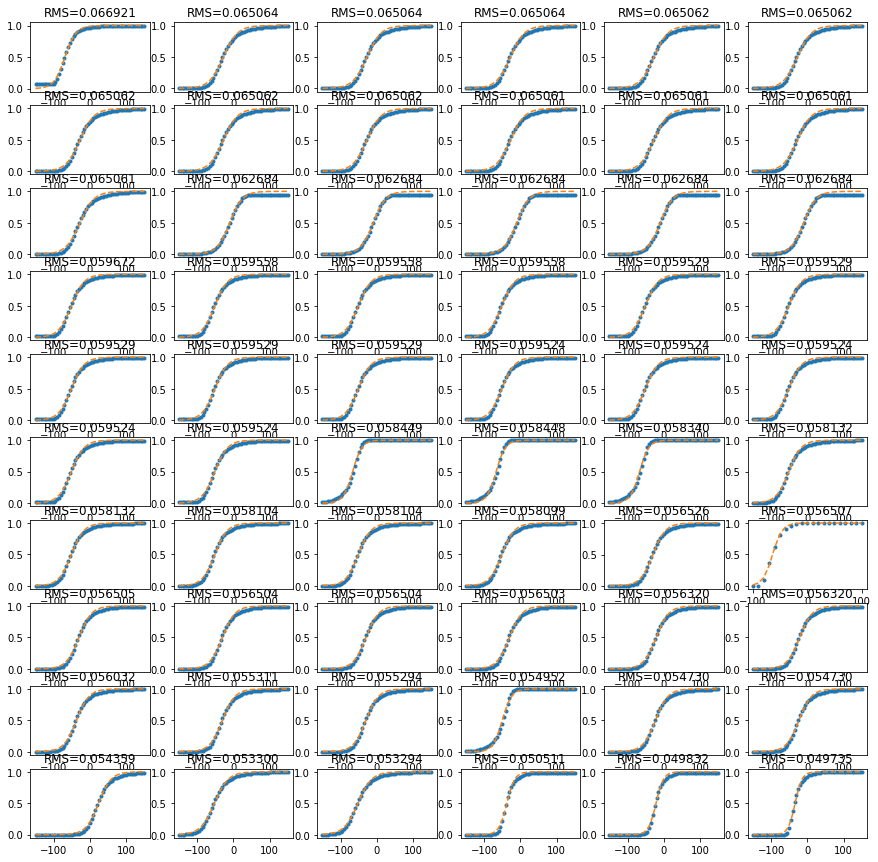

In [12]:
# plot some individual examples
# total_popt, total_rms, total_iontype, total_curvetype

# INF
rms_vals = [x for i,x in enumerate(total_rms) if (total_curvetype[i] == 'INF')]
rms_inds = [i for i,x in enumerate(total_rms) if (total_curvetype[i] == 'INF')]

# plot the worst ones
badfits = sorted(rms_vals, reverse=True)
badfits_inds = sorted(range(len(rms_vals)), key=lambda k: rms_vals[k],reverse=True)

plt.figure(figsize=(15,15))
c=0
for i in range(300,360):
    c += 1
    k = rms_inds[badfits_inds[i]]
    popt = total_popt[k]
    data = total_traces[k]
    V = v2 if len(data)==21 else v
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, sigmoid(V, *popt), '--')
    plt.title('RMS=%f' % badfits[i])


0.999400481276
2840


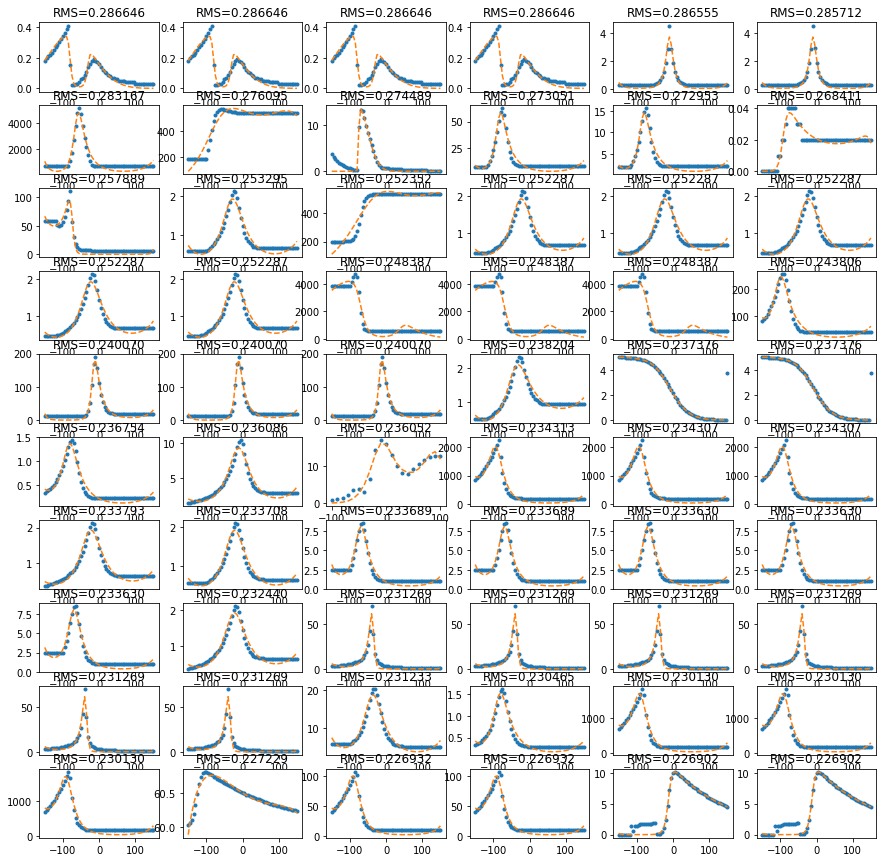

In [14]:
# plot some individual examples
# total_popt, total_rms, total_iontype, total_curvetype

# TAU
rms_vals = [x for i,x in enumerate(total_rms) if (total_curvetype[i] == 'TAU')]
rms_inds = [i for i,x in enumerate(total_rms) if (total_curvetype[i] == 'TAU')]
print(np.max(rms_vals))

# plot the worst ones
badfits = sorted(rms_vals, reverse=True)
badfits_inds = sorted(range(len(rms_vals)), key=lambda k: rms_vals[k],reverse=True)
print(len(badfits))

plt.figure(figsize=(15,15))
c=0
for i in range(500,560):
    c += 1
    k = rms_inds[badfits_inds[i]]
    popt = total_popt[k]
    data = total_traces[k]
    name = total_fnames[k]
    V = v2 if len(data)==21 else v
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, tau_fit_fcn(V, *popt), '--')
    plt.title('RMS=%f' % badfits[i])
    #plt.title(name,fontsize=7)



(2989, 2)
-785.39903305 1.02151808537
-53.0876140509 81.6577810565
(2840, 6)


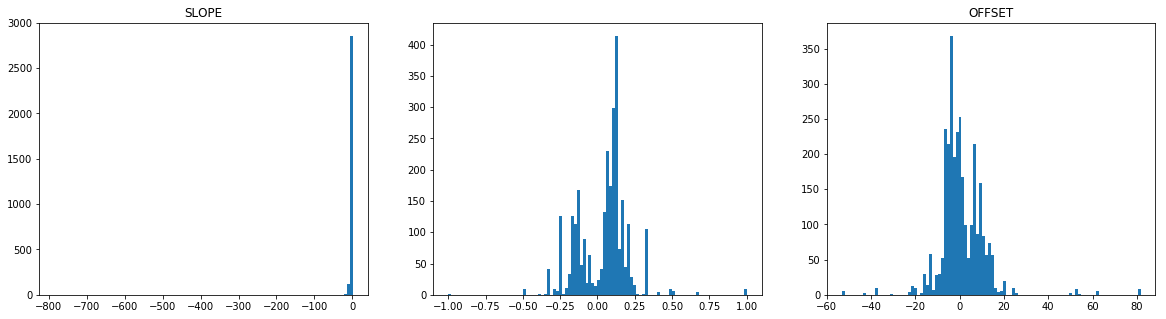

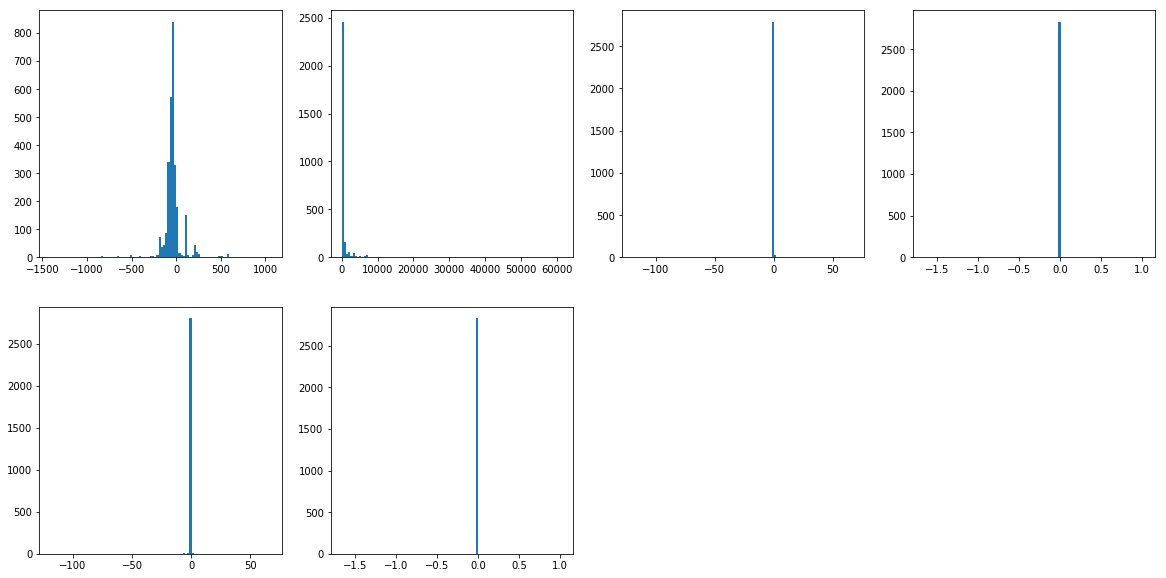

In [15]:
# collect all parameters

popt_all_inf = np.asarray([x for i,x in enumerate(total_popt) if (total_curvetype[i] == 'INF')])
print(popt_all_inf.shape)
print(np.min(popt_all_inf[:,0]),np.max(popt_all_inf[:,0]))
print(np.min(popt_all_inf[:,1]),np.max(popt_all_inf[:,1]))

plt.figure(figsize=(20,5))
plt.subplot(131)
h = plt.hist(popt_all_inf[:,0],range=(np.min(popt_all_inf[:,0]),np.max(popt_all_inf[:,0])),bins=100)
plt.title("SLOPE")
plt.subplot(132)
h = plt.hist(popt_all_inf[:,0],range=(-1,1),bins=100)
plt.subplot(133)
h = plt.hist(popt_all_inf[:,1],range=(np.min(popt_all_inf[:,1]),np.max(popt_all_inf[:,1])),bins=100)
plt.title("OFFSET")

popt_all_tau = np.asarray([x for i,x in enumerate(total_popt) if (total_curvetype[i] == 'TAU')])
print(popt_all_tau.shape)

plt.figure(figsize=(20,10))
for i in range(popt_all_tau.shape[1]):
    plt.subplot(2,4,i+1)
    h = plt.hist(popt_all_tau[:,i],range=(np.min(popt_all_tau[:,i]),np.max(popt_all_tau[:,i])),bins=100)
    
import pickle
if tau_order == 2:
    f = open("popt_2nd_order.pkl","wb")
else:
    f = open("popt_3rd_order.pkl","wb")
pickle.dump({'INF': popt_all_inf, 'TAU': popt_all_tau}, f)


In [75]:
param_data = {}

[2921, 2922, 2923, 2924]
[2921, 2922]
[2923, 2924]
[ 0.12455296  1.61932639]
[ 0.08030769 -4.24603633]
[ -2.21142439e+00   7.34421602e+00  -3.55341088e+01  -7.12101888e+01
   1.58956683e+03   1.81304097e+02  -2.69599557e+03  -1.17079127e+05]
[ -37.66356726    2.51778127   30.72046441  -12.85551687 -169.03253792
   29.69047563   25.15645311 -223.10741309]


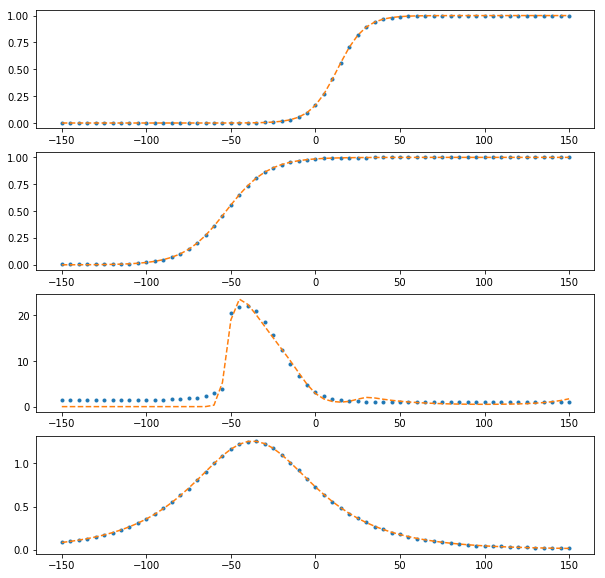

In [85]:
# plot individual models

#fname = '101629_naxn.mod'
varnames = ['INF_ACT','INF_INACT','TAU_ACT','TAU_INACT']
#fname = '155735_Kh1.mod'
#varnames = ['INF_ACT','TAU_ACT']
#fname = '62285_B_NA.mod'
#varnames = ['INF_INACT','INF_ACT','TAU_INACT','TAU_ACT']
#fname = '184303_Ca_HVA.mod'
#varnames = ['INF_ACT','INF_INACT','TAU_INACT','TAU_ACT']
fname = '138205_kadist.mod'

fname_inds = [i for i,x in enumerate(total_fnames) if (fname in x)]
#print(total_fnames)
print(fname_inds)

inf_inds = [j for j in fname_inds if total_curvetype[j] == 'INF']
tau_inds = [j for j in fname_inds if total_curvetype[j] == 'TAU']
print(inf_inds)
print(tau_inds)

subdata = {}

plt.figure(figsize=(10,10))
for i in range(len(fname_inds)):
    k = fname_inds[i]
    popt = total_popt[k]
    print(popt)
    data = total_traces[k]
    V = v2 if len(data)==21 else v
    plt.subplot(len(fname_inds),1,i+1)
    plt.plot(V, data, '.')
    if total_curvetype[fname_inds[i]] == 'INF':
        plt.plot(V, sigmoid(V, *popt), '--')
    else:
        plt.plot(V, tau_fit_fcn(V, *popt), '--')
    subdata[varnames[i]] = popt
    
#param_data.update({fname: subdata})
        


/Users/pedro/Documents/repos/channelomics/test_supermodel/supermodel.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a*x+b))
/Users/pedro/Documents/repos/channelomics/test_supermodel/supermodel.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/Users/pedro/Documents/repos/channelomics/test_supermodel/supermodel.py:9: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/Applications/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Applications/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1800.

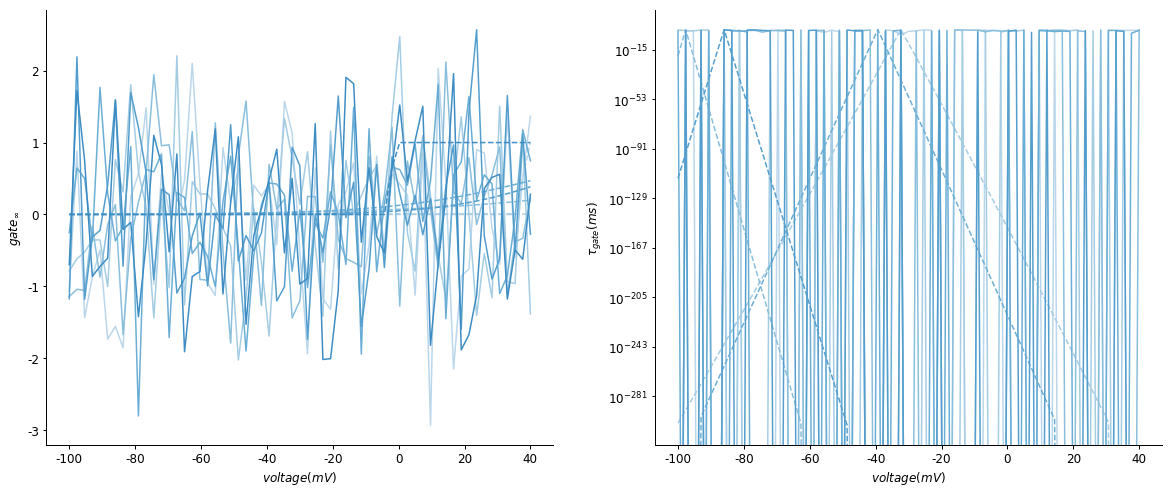

In [15]:
# plotting
col_offset = 4
num_colors = num_models+col_offset
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_offset,num_colors)]

# with PdfPages('database_supermodel_fits.pdf') as pdf:
0
fig = plt.figure(figsize=(20,8))

popt_inf_ls = []
popt_tau_ls = []
rms_inf_ls = []
rms_tau_ls = []
for i in range(num_models):

    # optimisation and plotting
    plt.subplot(121)
    popt, _ = curve_fit(sigmoid, V, y_inf[i])
    popt_inf_ls.append(popt)
    rms_inf_ls.append(np.sqrt(np.mean((y_inf[i]-sigmoid(V, *popt))**2)))
    plt.plot(V,y_inf[i], color=col1[i])
    plt.plot(V, sigmoid(V, *popt), color=col1[i], ls='--')
    plt.xlabel(r'$voltage (mV)$')
    plt.ylabel(r'$gate_{\infty}$')
    ax = plt.gca()

    plt.subplot(122)
    p0 = [V[np.argmax(y_tau[i])],np.max(y_tau[i]),0,0,0,0,0,0]
    popt, _ = curve_fit(tau_fit_fcn, V, y_tau[i], p0=p0)
    popt_tau_ls.append(popt)
    rms_tau_ls.append(np.sqrt(np.mean((y_tau[i]-tau_fit_fcn(V, *popt))**2)))
    plt.semilogy(V,y_tau[i],color=col1[i])
    plt.plot(V, tau_fit_fcn(V, *popt), color=col1[i], ls='--')
    plt.xlabel(r'$voltage (mV)$')
    plt.ylabel(r'$\tau_{gate} (ms)$')
    ax = plt.gca()

plt.show()
#     pdf.savefig()
plt.close()

In [ ]:

# with PdfPages('database_supermodel_fits_quality.pdf') as pdf:

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(popt_inf_ls)
plt.ylabel(r'$ rms gate_{\infty}$')

plt.subplot(122)
plt.hist(popt_tau_ls)
plt.ylabel(r'$rms \tau_{gate} (ms)$')

plt.show()
#     pdf.savefig()
plt.close()


## parameters obtained

In [ ]:
params_labels = [r'$a$', r'$b$', r'$V_H$', r'$A$', r'$b_1$', r'$c_1$', r'$d_1$', r'$b_2$', r'$c_2$', r'$d_2$']

# with PdfPages('database_supermodel_params.pdf') as pdf:

fig = plt.figure(figsize=(15,5))
popt_mat = np.concatenate((np.asarray(popt_inf_ls), np.asarray(popt_tau_ls)),axis=1)
for i in range(num_models):
    plt.semilogy(np.linspace(0,len(params_labels)-1,len(params_labels)),np.abs(popt_mat[i,:]),'o')
plt.ylabel('|parameter values|')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(params_labels)-1,len(params_labels)))
ax.set_xticklabels(params_labels)

plt.show()
#     pdf.savefig()
plt.close()